# Test the part of variance lost while making spectra with time window processing
- computing psd with fft.fft and an hann window -> variance = 3/8 true variance
- computind psd with scipy.signal.periodogram with hann window (used in get_spectrum) -> already corrected var = true var
- time windowing does not seem to loose variance for long time window compared to caracteritic period

In [1]:
import scipy.fft as fft
import scipy.signal as sg
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

## With fft
We refind the 0.375 value 

In [2]:
n = 1024
x = np.random.randn(n)

In [3]:
np.mean(x**2)

0.9714232375167965

In [4]:
fftxhann = fft.fft(x * sg.hann(n))
fftx = fft.fft(x)

In [5]:
print(np.sum(abs(fftx) ** 2) / n**2, np.sum(abs(fftxhann) ** 2) / n**2)

0.9714232375167964 0.38581946721983645


In [6]:
3 / 8

0.375

## With periodogram 
Seems corrected, but how ??

In [7]:
l = []
for i in range(10000):

    n = 1024
    x = np.random.randn(n)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})

    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    df = np.diff(fhann)[0]
    # print(np.sum(E), np.sum(Ehann),np.sum(Ehann)/np.sum(E))
    l.append(np.sum(Ehann) * df / np.mean(x**2))
print(np.mean(l))

0.9998650678900607


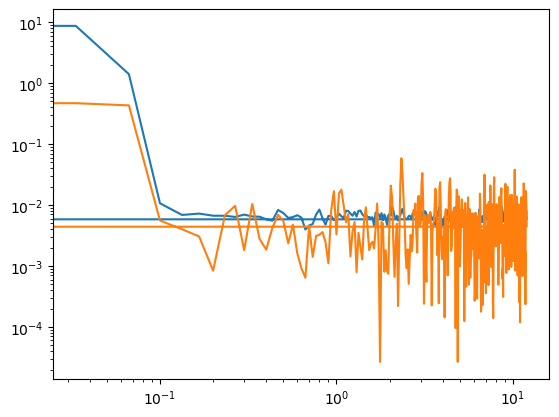

In [10]:
plt.plot(fhann, E)
plt.plot(fhann, Ehann)
plt.xscale("log")
plt.yscale("log")

In [11]:
?sg.periodogram

Signature:
sg.periodogram(
    x,
    fs=1.0,
    window='boxcar',
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
)
Docstring:
Estimate power spectral density using a periodogram.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window and its length must be nperseg. Defaults
    to 'boxcar'.
nfft : int, optional
    Length of the FFT used. If `None` the length of `x` will be
    used.
detrend : str or function or `False`, optional
    Specifies how to detrend each segment. If `detrend` is a
 

In [12]:
l = []
for i in range(1000):

    n = 1024
    t = 1 / 24 * np.arange(n)
    x = (
        sum([np.sin(2 * np.pi * t / T) for T in np.array([1, 6, 12, 24, 5]) / 24])
        + np.random.randn(n) * 0.4
    )
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})

    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    df = np.diff(fhann)[0]
    # print(np.sum(E), np.sum(Ehann),np.sum(Ehann)/np.sum(E))
    l.append(np.sum(Ehann) * df / np.mean(x**2))
print(np.mean(l))

1.0006683543371502


## With time window

Mean square from time serie [1.61463731 1.54162113 1.6529152  1.7240925  1.66401306 1.67169893
 1.71456384 1.81396354 1.69009289 1.50621663 1.65553369 1.76665589
 1.77109328 1.76441847 1.74960618 1.65196545 1.61847753 1.60793409
 1.57096693 1.65920383 1.71950644 1.63869885 1.64251698 1.61989272
 1.51339124 1.58491975 1.56600313 1.55945343 1.67959029 1.71741512
 1.69631446 1.72136313 1.66372469 1.63116851 1.62522603 1.59643518
 1.66676216 1.67186047]
Mean square from spectra [1.63012403 1.59193389 1.62207477 1.7692077  1.72491886 1.60707035
 1.69973566 1.79303999 1.74346872 1.52974263 1.56470782 1.85834801
 1.69186095 1.71996324 1.79483931 1.68983018 1.62295376 1.60662009
 1.59929197 1.65896719 1.57481723 1.69775093 1.72455464 1.55028731
 1.51452387 1.61069981 1.52434578 1.63012847 1.69593521 1.61811347
 1.72459571 1.79866945 1.58246524 1.56947334 1.55441201 1.66472272
 1.69314893 1.56180372]
Ratio 0.9984486694683821


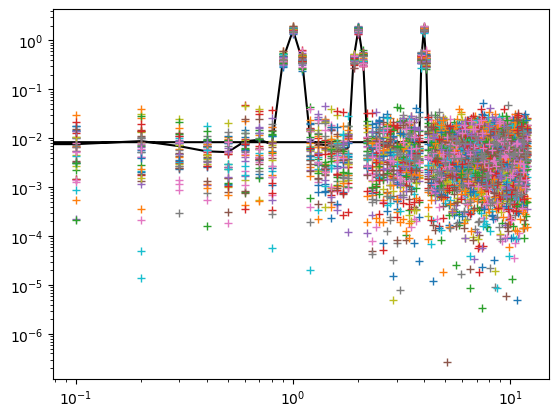

In [22]:
n = 24 * 200
t = 1 / 24 * np.arange(n)
# x a time serie
x = (
    sum(
        [
            np.sin(2 * np.pi * t / T)
            for T in np.array(
                [
                    1,
                    6,
                    12,
                    24,
                ]
            )
            / 24
        ]
    )
    + np.random.randn(n) * 0.4
)


imin, imax = 0, len(t)
T = 10 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []  # x time window list
_T = []  # time window list
_F = []  # frequency time window list
_Ehann = []  # spectra time window list
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        _x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

# Mean square value
_msX = np.mean(_X**2, axis=1)  # from time series
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df  # from spectra

print(f"Mean square from time serie {_msX}")
print(f"Mean square from spectra {_msE}")
print(f"Ratio {(_msE/_msX).mean()}")

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

## With bigger time window

Mean square from time serie [1.20485185 0.30491703 1.1395908  1.99950391 1.15409985 0.30032568
 1.12981072 2.05841118 1.22735407 0.30366855 1.16886108 2.03572969]
Mean square from spectra [1.1641687 1.1641687 1.1641687 1.1641687 1.1641687 1.1641687 1.1641687
 1.1641687 1.1641687 1.1641687 1.1641687 1.1641687]
Ratio 1.6015937918871472


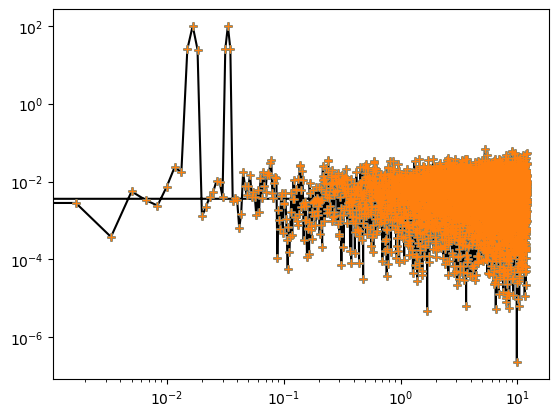

In [21]:
n = 24 * 200
t = 1 / 24 * np.arange(n)
# x = sum([np.sin(2*np.pi*t/T) for T in np.array([1,6,12,24,])/24])+ np.random.randn(n)*0.4

imin, imax = 0, len(t)
T = 30 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df


print(f"Mean square from time serie {_msX}")
print(f"Mean square from spectra {_msE}")
print(f"Ratio {(_msE/_msX).mean()}")

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

Mean square from time serie [1.16487419 0.31965095 1.17011713 2.008142   1.15316206 0.31525922
 1.21482535 2.03917279 1.13403611 0.30324657 1.16285383 2.02807097
 1.17478992 0.34649341 1.1822876  2.04592282 1.19647193 0.29115779
 1.14388273 1.98063417 1.13998388 0.30600575 1.09987074 1.93795496
 1.13695884 0.31486822 1.18112493 2.03017531 1.17806997 0.32811443
 1.20146414 2.10533452 1.20998436 0.30105037 1.21181297 2.07589386
 1.18645908 0.30930226]
Mean square from spectra [1.39897352 0.21586614 1.46221746 1.21655196 1.41636065 0.2189015
 1.46018503 1.32701921 1.33546756 0.22983386 1.39083327 1.27347271
 1.44632158 0.22950642 1.45758997 1.27253256 1.45336202 0.20461164
 1.37654196 1.24497841 1.40165167 0.21949528 1.37231721 1.154457
 1.41686749 0.21753239 1.42719896 1.27493727 1.45287091 0.22989504
 1.50153891 1.32498765 1.44503646 0.20957681 1.51803865 1.26914483
 1.4749508  0.21678129]
Ratio 0.9431448741116943


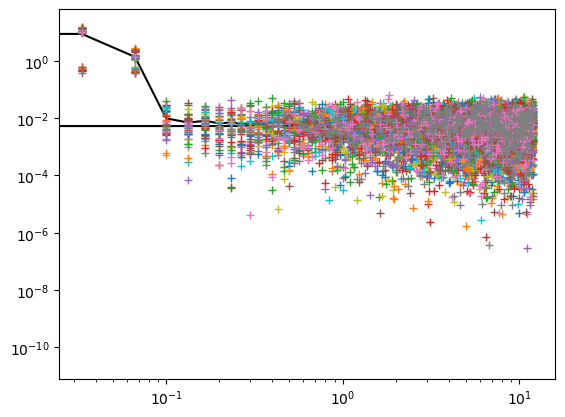

In [23]:
n = 24 * 30 * 20
t = 1 / 24 * np.arange(n)
x = (
    sum([np.sin(2 * np.pi * t / T) for T in np.array([24 * 30, 24 * 60]) / 24])
    + np.random.randn(n) * 0.4
)

imin, imax = 0, len(t)
T = 30 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        _x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df


print(f"Mean square from time serie {_msX}")
print(f"Mean square from spectra {_msE}")
print(f"Ratio {(_msE/_msX).mean()}")

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")